# Generate an inter-species test set from [APID](http://cicblade.dep.usal.es:8080/APID/init.action)
#### boilerplate

In [1]:
from __future__ import annotations

import os
import sys
import shutil
import importlib

from pathlib import Path

from dataclasses import field
from itertools import product
from typing import Callable

import numpy as np
import pandas as pd
import requests
from dataclass_wizard import JSONWizard

Mess around with paths because I'm running this a few times on different systems.

In [2]:
!which python
!pwd

/home/k/kaindll/mambaforge/envs/ppi/bin/python
/home/k/kaindll


In [3]:
if 'kaindl' in str(cwd := Path.cwd()):
    cwd = Path('/home/k/kaindll/ppi/data/ppi_dataset/template')
package_root = str(cwd.parents[2])
if package_root not in sys.path:
    sys.path.append(package_root)
package_root

'/home/k/kaindll/ppi'

In [4]:
session = '7082'
session_dir = cwd.parent / 'results' / session

assert session_dir.is_dir(), 'use on a previously generated dataset!'
os.chdir(session_dir.resolve())
!pwd

/home/k/kaindll/ppi/data/ppi_dataset/results/7082


In [5]:
from data.utils.cfg import Config, SamplingStrategy
from data.utils import api, extract, general, pairs, plot, reduce, proteome

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

#### config
These are the somewhat relevant settings. Have a look!

In [6]:

@dataclass
class Params(JSONWizard):
    class _(JSONWizard.Meta):
        key_transform_with_dump = 'SNAKE'

    keep_human: bool = False
    keep_interspecies: bool = False
    accept_homodimers: bool = False
    add_proteomes: bool = True
    slurm: bool = all(shutil.which(t) for t in ('snakemake', 'sbatch'))
    slurm_node_limit: int = 15
    rostclust: bool = shutil.which('rostclust')

    min_seq_len: int = 50
    max_seq_len: int = 1500

    seed: int = 42
    ratio: float = 10.0
    strategy: SamplingStrategy = SamplingStrategy.BALANCED

    val_set_size: float = .1
    val_species: set[str] = field(default_factory=set)


hval_config = dict(shortAlignmentLen=50,
                   longSeqLen=180,
                   reduceRandomAlign=False,
                   clusterThreshold=20)

train_species = set()  # select only this subset
val_species = set()
test_species = set()
params = Params()

The detour below is meant to keep the class definition above short, and the `Config` class importable from other modules.

In [7]:
c = Config(
    **params.to_dict() | dict(
        hval_config=hval_config,
        train_species=train_species,
        val_species=val_species,
        test_species=test_species,
        cwd=session_dir, strategy=params.strategy
    ))

#### importlib
For development, it's nice to be able to edit the imported modules.

In [8]:
importlib.reload(api)
importlib.reload(extract)
importlib.reload(general)
importlib.reload(pairs)
importlib.reload(plot)
importlib.reload(reduce)
importlib.reload(proteome)

from data.utils.api import *
from data.utils.extract import *
from data.utils.general import *
from data.utils.pairs import *
from data.utils.plot import *
from data.utils.reduce import *
from data.utils.proteome import *

In [9]:
# maybe fix this!
c.pp = c.ip / 'proteomes'
c.pp.mkdir(parents=True, exist_ok=True)
c.pp

PosixPath('apid_isp/proteomes')

#### Create inter-species set

#### plot the size of the inter-species sets
First, re-read the interactomes *with* human; and *with vs. without* interspecies

In [10]:
ip_noisi = unzip_apid(zip_path='apid.zip', work_dir=c.ip / 'noISI',
                      keep_human=True, keep_interspecies=False)
ip_noisi

PosixPath('apid_isp/noISI/apid_q1')

In [11]:
noisi_ids = extract_apid_uniprot_ids(ip_noisi)
len(noisi_ids)

61429

In [12]:
noisi_ppis = extract_apid_ppis(ip_noisi)
len(noisi_ppis)

296653

In [13]:
ipo = unzip_apid(zip_path='apid.zip', work_dir=c.ip / 'ISI',
                 keep_human=True, keep_interspecies=True)
isp_ids = extract_apid_uniprot_ids(ipo)
isp_ppis = extract_apid_ppis(ipo)
len(isp_ids), len(isp_ppis.species.unique())

(67240, 35)

In [14]:
taxonomy = fetch_taxonomic_info(isp_ppis.species).sort_values(by='n_ppis')
taxonomy.loc[taxonomy.name.str.startswith('Campylob'),
             'name'] = 'Campylobacter jejuni'
taxonomy.loc[taxonomy.name.str.startswith('Sever'),
             'name'] = 'SARS-CoV 2'
taxonomy

100%|████████████████████████████████████████████████| 35/35 [00:17<00:00,  1.99it/s]


,species,name,n_ppis
34,2697049,SARS-CoV 2,26
27,272634,Mycoplasma pneumoniae M129,35
25,237561,Candida albicans SC5314,49
13,10299,Human alphaherpesvirus 1 strain 17,59
10,9986,Oryctolagus cuniculus,79
32,868565,Human herpesvirus 8 strain GK18,85
15,10600,Human papillomavirus type 6b,92
18,37296,Human gammaherpesvirus 8,98
16,11706,HIV-1 M:B_HXB2R,101
6,8355,Xenopus laevis,116


In [42]:
(taxonomy[['species', 'name']].sort_values(by='species')
 .to_csv('taxonomy.tsv', sep='\t', index=False))

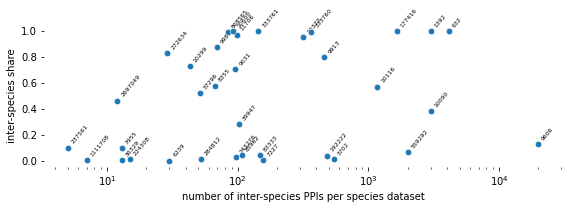

In [43]:
fig, dq2 = plot_interspecies_loss(noisi_ppis, isp_ppis, taxonomy)
# fig.savefig('inter_species_share_new.svg')

In [15]:
# focus on the species from main APID dataset
c.test_species = {int(p.stem.split('_')[0]) for p in glob_types(
    c.cwd / 'apid_q1', ['_noISI_Q1.txt', '_noISI_Q1.txt.bak'])} | {9606}
len(c.test_species)

32

#### download all sequences

In [16]:
uniprot_ids = noisi_ids | isp_ids
len(uniprot_ids)

67240

In [54]:
# skip if re-running this w/o changes above or deleting files
id_hash_lookup = uniprot_api_fetch(uniprot_ids, c.ip / 'apid' / 'apid')

jobId: ba1db81f0c038f69c129e473889b81bc98a430fa
apid: query + tab ...b'{"results":[{"from":"A0A021WW32","to":"A0A021WW32"},{"from":"A0A023PXA5","to":"A0A023PXA5"},{"from":"A0A023PYF7","to":"A0A023PYF7"},{"from":"A0A024A2C9","to":"A0A024A2C9"},{"from":"A0A024R0Y4","to":
 67242:0
apid: fasta ...API FASTA: ae28923e7e3ccb15e7acb119e868410cec879cded04b5a8e6e68b993544592cb


hash FASTA: 67011it [00:18, 3563.83it/s]
fetch isoforms/archive: 100%|████████████████████████| 89/89 [06:16<00:00,  4.23s/it]


In [17]:
with (c.ip / 'apid' / 'apid.json').open('r') as json_file:
    id_hash_lookup = json.load(json_file)
len(id_hash_lookup)

67240

#### extract second species
When downloading sequences, the original descriptive headers from an intermediate FASTA were extracted as a TSV. This table contains `OX=` information almost everywhere by default, and we added this information for UniParc entries.

In [18]:
upmp = pd.read_csv(c.ip / 'apid' / 'apid.tsv', sep='\t', header=0)
upmp['ox'] = upmp.description.str.extract('.*OX=(\d+).*').astype(int)
upmp.head()

,From,To,crc_hash,source,description,ox
0,P61247,P61247,CRC-000037AE195F7A9D,query,sp|P61247|RS3A_HUMAN 40S ribosomal protein S3a...,9606
1,Q9FG13,Q9FG13,CRC-000140D8BB91126A,query,sp|Q9FG13|CXE15_ARATH Probable carboxylesteras...,3702
2,Q9BSF4,Q9BSF4,CRC-000324A28C9F2902,query,sp|Q9BSF4|TIM29_HUMAN Mitochondrial import inn...,9606
3,Q0PAI7,Q0PAI7,CRC-0004FA7836A741E8,query,tr|Q0PAI7|Q0PAI7_CAMJE Putative membrane prote...,192222
4,Q12193,Q12193,CRC-0004FB11FB8C8068,query,sp|Q12193|YB12B_YEAST Transposon Ty1-BR Gag-Po...,559292


In [19]:
upmp.loc[upmp.ox.isna()]  # all records have a taxon ID!

,From,To,crc_hash,source,description,ox


In [20]:
len(upmp), len(uniprot_ids)

(67242, 67240)

There are two additional lines!

In [21]:
vcs = pd.DataFrame(upmp.From.value_counts())
vcs.loc[vcs.From > 1]

,From
Q8ML70,2
Q9SN96,2


These are de-merged entries, but they actually have the same sequence.

In [22]:
upmp.loc[upmp.From.isin(vcs.loc[vcs.From > 1].index)]

,From,To,crc_hash,source,description,ox
25234,Q8ML70,C0HLZ9,CRC-6080064ABCC1CC3D,query,sp|C0HLZ9|BARA1_DROME Baramicin A1 OS=Drosophi...,7227
25235,Q8ML70,C0HM00,CRC-6080064ABCC1CC3D,query,sp|C0HM00|BARA2_DROME Baramicin A2 OS=Drosophi...,7227
39454,Q9SN96,P0DO44,CRC-96CEA6088EEBAA32,query,sp|P0DO44|ATP6A_ARATH ATP synthase small subun...,3702
39455,Q9SN96,P0DO45,CRC-96CEA6088EEBAA32,query,sp|P0DO45|ATP6B_ARATH ATP synthase small subun...,3702


Maybe check if the associated organism has changed somewhere? Answer: Secondary accession numbers arise when entries are *merged*. This pre-supposes that they belong to the same organism!

In [23]:
upmp.loc[upmp.From != upmp.To].sort_values(by='crc_hash')

,From,To,crc_hash,source,description,ox
290,D3YT24,Q19336,CRC-010FA1B1CE076FF8,query,sp|Q19336|PCGF3_CAEEL Polycomb group RING fing...,6239
308,Q8VYG7,F4K6B8,CRC-011FD4BC2B74DCBA,query,sp|F4K6B8|RGI4_ARATH Leucine-rich repeat recep...,3702
4643,Q8VCD0,P35918,CRC-11859F8A58A33A39,query,sp|P35918|VGFR2_MOUSE Vascular endothelial gro...,10090
5053,Q09636,Q4JFH9,CRC-1307E916ECFB95E5,query,sp|Q4JFH9|CRH2_CAEEL CREB homolog crh-2 OS=Cae...,6239
5054,Q4JFI0,Q4JFH9,CRC-1307E916ECFB95E5,query,sp|Q4JFH9|CRH2_CAEEL CREB homolog crh-2 OS=Cae...,6239
...,...,...,...,...,...,...
56899,H2KY85,H2KY84,CRC-D8EF18E9C64C97E4,query,sp|H2KY84|CMTA1_CAEEL Calmodulin-binding trans...,6239
58311,Q65XX0,H2KY86,CRC-DE32173B3E42F773,query,sp|H2KY86|HELQ_CAEEL Helicase POLQ-like OS=Cae...,6239
59093,Q9LZG3,A0A1I9LQ12,CRC-E0F58B9B008C14DA,query,sp|A0A1I9LQ12|O3L2_ARATH Protein OXIDATIVE STR...,3702
60081,G5EGU6,G5EGB2,CRC-E48DFFA50437E78F,query,sp|G5EGB2|LIN29_CAEEL Zinc finger transcriptio...,6239


In [24]:
upmp.loc[upmp.From != upmp.To, 'source'].unique()

array(['query'], dtype=object)

In [25]:
# make a species lookup
ox = upmp[['From', 'ox']].set_index('From').to_dict()['ox']

In [26]:
for ppis in [noisi_ppis, isp_ppis]:
    for ch in 'AB':
        ppis[f'species_{ch}'] = ppis[f'UniprotID_{ch}'].apply(ox.get)
noisi_ppis.loc[(noisi_ppis.species_A != noisi_ppis.species_B) | (noisi_ppis.species_B != noisi_ppis.species)]

,UniprotID_A,UniprotID_B,species,species_A,species_B
26105,A0A087WVE9,Q13137,9606,9598,9606
26106,A0A087WVE9,Q01850,9606,9598,9606
26107,A0A087WVE9,Q6P2R3,9606,9598,9606
26108,A0A087WVE9,Q96MT8,9606,9598,9606
26109,A0A087WVE9,Q13363,9606,9598,9606
...,...,...,...,...,...
2537,C0H4E8,Q8IHN6,36329,1036723,36329
2538,C0H4E8,Q8I2W4,36329,1036723,36329
2620,Q8I398,Q8IK79,36329,36329,5843
2624,Q8I2V4,Q8IK80,36329,36329,5843


This is interesting to see! But still it's just a few.

In [27]:
(noisi_ppis.loc[(noisi_ppis.species_A != noisi_ppis.species_B),
                ['species', 'species_A', 'species_B']]
 .melt(id_vars='species', value_name='alias')[['species', 'alias']]
 .drop_duplicates().set_index('alias'))

,species
alias,
9598,9606
5843,36329
36329,36329
1036725,36329
137071,36329
1036723,36329
9606,9606


In [28]:
aliases = (noisi_ppis.loc[(noisi_ppis.species_A != noisi_ppis.species_B),
                          ['species', 'species_A', 'species_B']]
    .melt(id_vars='species', value_name='alias')[['species', 'alias']]
    .drop_duplicates().set_index('alias').to_dict()['species'])
# if 9598 in aliases and aliases[9598] == 9606:
#     aliases.pop(9598)
aliases

{9598: 9606,
 5843: 36329,
 36329: 36329,
 1036725: 36329,
 137071: 36329,
 1036723: 36329,
 9606: 9606}

A check shows that those are in fact mostly varieties of Plasmodium, and some monkeys.
Let's use those as aliases!

    5843    Plasmodium falciparum NF54
    137071  Plasmodium falciparum HB3
    1036723 Plasmodium falciparum Vietnam Oak-Knoll (FVO)
    1036725 Plasmodium falciparum Tanzania (2000708)
    9598    chimp
    60711   meerkat

In [29]:
for ppis in [noisi_ppis, isp_ppis]:
    for ch in 'AB':
        ppis[f'species_{ch}'] = ppis[f'species_{ch}'].apply(lambda sp: aliases.get(sp, sp))

Now isolating the inter-species PPIs is super easy:

In [30]:
inter_ppis = (isp_ppis.loc[isp_ppis.species_A != isp_ppis.species_B]
              .copy().drop('species', axis=1, errors='ignore'))
intra_ppis = noisi_ppis.copy().drop(['species_A', 'species_B'], axis=1, errors='ignore')
inter_ppis  # 38544

,UniprotID_A,UniprotID_B,species_A,species_B
85,O31466,Q9X6J6,224308,1422
415,P08877,Q9RE09,224308,1582
417,P09122,Q9X4C9,224308,1422
459,A0A0H2UQA6,P16971,170187,224308
473,P18429,Q8H0K8,224308,4565
...,...,...,...,...
1645,Q5NIP8,Q9NZM1,177416,9606
1646,P19838,Q5NIQ1,9606,177416
1647,Q5NIQ1,Q9NZM3,177416,9606
1648,Q5NIQ5,Q6ZMY6,177416,9606


In [31]:
len(noisi_ppis), len(isp_ppis.loc[isp_ppis.species_A == isp_ppis.species_B])

(296653, 296654)

In [32]:
joined = noisi_ppis.merge(isp_ppis.loc[isp_ppis.species_A == isp_ppis.species_B],
                          how='outer',
                          on=['UniprotID_A', 'UniprotID_B'], indicator=True).convert_dtypes()
print(len(joined))
joined.head()

296654


,UniprotID_A,UniprotID_B,species_x,species_A_x,species_B_x,species_y,species_A_y,species_B_y,_merge
0,Q9UW12,Q9UW14,237561,237561,237561,237561,237561,237561,both
1,Q8X1E6,Q9Y7W4,237561,237561,237561,237561,237561,237561,both
2,A0A1D8PN90,Q8X1E6,237561,237561,237561,237561,237561,237561,both
3,A0A1D8PN90,Q9Y7W4,237561,237561,237561,237561,237561,237561,both
4,Q5AHJ5,Q5AHJ5,237561,237561,237561,237561,237561,237561,both


In [33]:
joined.loc[joined._merge != 'both']

,UniprotID_A,UniprotID_B,species_x,species_A_x,species_B_x,species_y,species_A_y,species_B_y,_merge
296653,H2QD90,P63000,<NA>,<NA>,<NA>,9606,9606,9606,right_only


In [34]:
!grep "P63000" "apid_isp/ISI/apid_q1/9606_Q1.txt" | grep "H2Q"

2229268	P63000	RAC1_HUMAN	RAC1	H2QD90	H2QD90_PANTR	ARHGAP27	1	1	1	0	1


In [35]:
!grep "P63000" "apid_isp/noISI/apid_q1/9606_noISI_Q1.txt" | grep "H2Q"

So aliasing got this one wrong. No matter!

In [36]:
len(inter_ppis.drop_duplicates())

22775

In [37]:
# order the species and drop duplicates
ab = lambda ab: [a + b for a, b in product(['UniprotID_', 'species_'], ab)]
inter_ppis.loc[inter_ppis.species_A > inter_ppis.species_B, ab('AB')] = inter_ppis.loc[
    inter_ppis.species_A > inter_ppis.species_B, ab('BA')].values
inter_ppis = inter_ppis.drop_duplicates().convert_dtypes()
len(inter_ppis)  # 22775

22775

Dropping duplicates before re-ordering would have directly resulted in 22775 records as well - This is due to records only always appearing in the same direction across multiple files from APID (both `Q1`s)!

#### limit to reasonable 32 spp

In [38]:
# limit to reasonable species
inter_ppis = inter_ppis.loc[(inter_ppis.species_A.isin(c.test_species))
                            & (inter_ppis.species_B.isin(c.test_species))]
len(inter_ppis)  # 13713

13713

In [39]:
# map IDs to seq hashes
hash_isp_ppis = ppis_to_hashes(inter_ppis, c.ip / 'apid' / 'apid.json',
                               horizontal_sort=False, dedup=True)
hash_isp_ppis  # 13700

,hash_A,hash_B,species_A,species_B
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606
1,CRC-0008E21D66E8CFEC,CRC-58C50DEBDE83D5F3,9606,10116
2,CRC-0008E21D66E8CFEC,CRC-B74C3858C20EF82C,9606,11706
3,CRC-000E386A13F6E3E9,CRC-0B0C581E2454631E,632,9606
4,CRC-000E386A13F6E3E9,CRC-EC228BD0C9E643F1,632,9606
...,...,...,...,...
13695,CRC-FFC2D74E485E2B61,CRC-E173C872D195F028,632,9606
13696,CRC-FFC2D74E485E2B61,CRC-F36EE9FBF64DF162,632,9606
13697,CRC-FFD857F4C11BC0DB,CRC-A3C2B941BECDB178,9606,10090
13698,CRC-FFE545D1BEC87892,CRC-E69F1357D72E94F4,9606,10377


In [40]:
hash_isp_ppis.loc[hash_isp_ppis.hash_A == hash_isp_ppis.hash_B]
# oh for f*'s sake

,hash_A,hash_B,species_A,species_B
10200,CRC-C33CDD2C1B13C397,CRC-C33CDD2C1B13C397,9606,10090


In [41]:
hash_isp_ppis = drop_homodimers(hash_isp_ppis)

In [42]:
d1 = hash_isp_ppis[['species_A', 'species_B']].melt()['value'].value_counts()
d1

9606       12926
632         3959
1392        2989
10090       2452
559292      1934
10116       1130
333760       367
9913         348
3702         255
10377        223
7227         141
11706         96
9031          88
868565        77
8355          66
9986          63
39947         55
284812        45
10299         35
6239          29
272634        29
37296         26
83333         18
7955          12
2697049       12
36329         11
237561         5
224308         4
85962          2
1111708        1
Name: value, dtype: int64

In [43]:
d2 = hash_isp_ppis[['species_A', 'species_B']].value_counts()
d2

species_A  species_B
632        9606         3959
1392       9606         2988
9606       10090        2074
           559292       1788
           10116         836
                        ... 
6239       9913            1
1392       8355            1
3702       10090           1
           1111708         1
10090      11706           1
Length: 90, dtype: int64

#### read and filter sequences

In [44]:
inter_hashes = set(np.unique(hash_isp_ppis.iloc[:, [0, 1]]))
len(inter_hashes)  # 14313(?) for all, 10063 w/o

10063

In [45]:
fasta = SeqIO.to_dict(SeqIO.parse(c.ip / 'apid' / 'apid.hash.fasta', 'fasta'))
fasta = {k: v for k, v in fasta.items() if k in inter_hashes}
len(fasta)

10063

dropped 1718/13699 PPIs from length filtering
dropped 0/9122 table IDs and 0/11981 rows, and 941/10063 sequence IDs


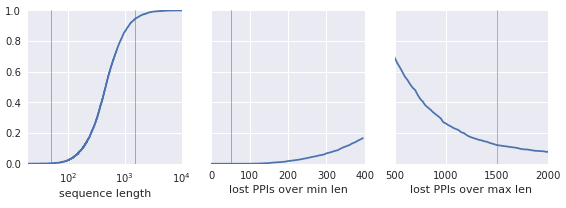

In [46]:
hash_isp_ppis, fasta, _ = filter_ppis_and_fasta_by_len(
    hash_isp_ppis.copy(), fasta, c.min_seq_len, c.max_seq_len)

In [47]:
len(hash_isp_ppis), len(fasta)

(11981, 9122)

In [88]:
_ = SeqIO.write(values_sorted_by_key(fasta), c.isp_raw_fasta, 'fasta')
hash_isp_ppis.to_csv(c.isp_raw_tsv, sep='\t', header=True, index=False)
c.isp_raw_fasta, c.isp_raw_tsv

(PosixPath('apid_isp/apid_interspecies_raw.fasta'),
 PosixPath('apid_isp/apid_interspecies_raw.tsv'))

#### cluster the positives

In [89]:
# cluster against val
run_uniqueprot2D(c.isp_raw_fasta, c.val_fasta, c.isp_nr_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_isp/apid_interspecies_raw.fasta apid_validation.fasta apid_isp/apid_interspecies_nr_val.fasta
using temporary directory apid_isp/apid_interspecies_rawb7g494tz
extract hvals from alignments: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]
 6847/9122::4357 non-redundant in apid_isp/apid_interspecies_raw.fasta against apid_validation.fasta written to apid_isp/apid_interspecies_nr_val.fasta


In [90]:
# red-reduce
run_uniqueprot(c.isp_nr_fasta, c.isp_rr_fasta,
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json apid_isp/apid_interspecies_nr_val.fasta apid_isp/apid_interspecies_rr_val.fasta
using temporary directory apid_isp/apid_interspecies_nr_valtvqxw4rn
extract hvals from alignments: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
 5032/6847 non-redundant in apid_isp/apid_interspecies_nr_val.fasta written to apid_isp/apid_interspecies_rr_val.fasta


In [91]:
# shrink
shrink_files_both_ways(c.isp_raw_tsv, c.isp_rr_fasta, c.isp_rr_tsv, c.isp_rr_fasta)

dropped 4090/9122 table IDs and 8557/11981 rows, and 1758/5032 sequence IDs


In [78]:
isp = pd.read_csv(c.isp_rr_tsv, sep='\t', header=0)
isp  # 3424

,hash_A,hash_B,species_A,species_B,minlen,maxlen
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606,245,1429
1,CRC-001576EA78C61C85,CRC-9BD612534CD2C9EB,9606,333760,98,230
2,CRC-003F04A89D9D9298,CRC-5B57ABE4DF6E396E,632,9606,622,800
3,CRC-004D9CE1FF661B75,CRC-2BD0B32F33D454DA,1392,9606,798,891
4,CRC-0054C7CD3E6A8446,CRC-9BD612534CD2C9EB,9606,333760,98,119
...,...,...,...,...,...,...
3419,CRC-FF13DDD5EBE47754,CRC-A5409FAF1594854C,9606,559292,357,381
3420,CRC-FF6AE6EBC632C805,CRC-1D09F2E0987F003B,1392,9606,88,829
3421,CRC-FF6AE6EBC632C805,CRC-D33F31EDAEA77D2A,1392,9606,88,256
3422,CRC-FF7DA1DD115285DD,CRC-2F8D1C7169A7817E,632,9606,155,375


In [79]:
c.test_species = set(np.unique(isp[['species_A', 'species_B']]))
len(c.test_species)

24

In [80]:
isp[['species_A', 'species_B']].melt()['value'].value_counts()

9606       3380
632        1391
559292      756
1392        682
10090       214
333760      179
10377        81
11706        40
10116        27
3702         16
7227         12
10299        12
9986         10
9913          9
6239          8
284812        6
272634        6
9031          5
2697049       4
8355          3
37296         3
83333         2
7955          1
1111708       1
Name: value, dtype: int64

In [81]:
isp.loc[isp.species_B == 7955]

,hash_A,hash_B,species_A,species_B,minlen,maxlen


#### prep extra negative candidates
Use APID proteins that do not have inter-species interactions as donors of extra negatives. Potentially supplement with SwissProt. The fact that they do not have positives does not matter, because this will become a **test** set.

In [85]:
crc_to_sp = write_json({v: ox[k] for k, v in id_hash_lookup.items()}, 'crc_to_sp.json')

In [83]:
# filter out isp proteins and sequences of wrong length from all proteins in our dataset
non_isp_seqs = {k: v for k, v in SeqIO.to_dict(SeqIO.parse(
    c.ip / 'apid' / 'apid.hash.fasta', 'fasta')).items()
                if k not in fasta.keys()
                and c.min_seq_len <= len(v) <= c.max_seq_len
                and crc_to_sp[k] in c.test_species}
len(non_isp_seqs)

48262

In [101]:
# write all the non-isp proteins to a single FASTA
_ = SeqIO.write(values_sorted_by_key(non_isp_seqs),
                c.pp / 'apid_non_interspecies_raw.fasta', 'fasta')

In [102]:
# cluster against val
run_uniqueprot2D(c.pp / 'apid_non_interspecies_raw.fasta',
                 c.val_fasta, c.pp / 'apid_non_interspecies_nr_val.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_isp/proteomes/apid_non_interspecies_raw.fasta apid_validation.fasta apid_isp/proteomes/apid_non_interspecies_nr_val.fasta
using temporary directory apid_isp/proteomes/apid_non_interspecies_rawlgpcx0mj
extract hvals from alignments: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]
 41566/48262::4357 non-redundant in apid_isp/proteomes/apid_non_interspecies_raw.fasta against apid_validation.fasta written to apid_isp/proteomes/apid_non_interspecies_nr_val.fasta


In [103]:
# cluster against the positives
run_uniqueprot2D(c.pp / 'apid_non_interspecies_nr_val.fasta', c.isp_rr_fasta,
                 c.pp / 'apid_non_interspecies_nr_val_isp.fasta',
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_isp/proteomes/apid_non_interspecies_nr_val.fasta apid_isp/apid_interspecies_rr_val.fasta apid_isp/proteomes/apid_non_interspecies_nr_val_isp.fasta
using temporary directory apid_isp/proteomes/apid_non_interspecies_nr_vald3xhhova
extract hvals from alignments: 100%|██████████| 17/17 [00:02<00:00,  6.80it/s]
 35922/41566::3274 non-redundant in apid_isp/proteomes/apid_non_interspecies_nr_val.fasta against apid_isp/apid_interspecies_rr_val.fasta written to apid_isp/proteomes/apid_non_interspecies_nr_val_isp.fasta


In [104]:
# red-reduce
run_uniqueprot(c.pp / 'apid_non_interspecies_nr_val_isp.fasta',
               c.pp / 'apid_non_interspecies_rr_val_isp.fasta',
               c.hval_config_path, not c.rostclust)

rostclust uniqueprot --hval-config-path hval_config.json apid_isp/proteomes/apid_non_interspecies_nr_val_isp.fasta apid_isp/proteomes/apid_non_interspecies_rr_val_isp.fasta
using temporary directory apid_isp/proteomes/apid_non_interspecies_nr_val_ispuimdu15i
extract hvals from alignments: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
 22632/35922 non-redundant in apid_isp/proteomes/apid_non_interspecies_nr_val_isp.fasta written to apid_isp/proteomes/apid_non_interspecies_rr_val_isp.fasta


In [105]:
assert (c.pp / 'apid_non_interspecies_rr_val_isp.fasta').is_file()

In [106]:
# read the proteins back to memory, divy up by species
apid_proteome = {int(sp): dict() for sp in c.test_species}
for _id, seqrecord in SeqIO.to_dict(SeqIO.parse(
        c.pp / 'apid_non_interspecies_rr_val_isp.fasta', 'fasta')).items():
    sp = crc_to_sp[_id]
    if sp not in apid_proteome:
        continue
    apid_proteome[sp][_id] = {'seq': str(seqrecord.seq),
                              'source': 'apid',
                              'id': _id}
# dump immediately
_ = write_json(apid_proteome, c.pp / 'apid_proteome.json')

In [107]:
# do not skip this step!
sp_path = Path('swissprot')
spp = filter_proteomes(sp_path, c.min_seq_len, c.max_seq_len,
                       [c.pp / 'apid_non_interspecies_raw.fasta', c.isp_raw_fasta])
assert not c.test_species - spp

100%|██████████████████████████████████████████████| 279/279 [00:16<00:00, 16.62it/s]


#### snakemake

In [108]:
len(c.test_species)

24

In [131]:
package_root

'/home/k/kaindll/ppi'

In [132]:
cc = c.to_dict() | dict(pkg_root=package_root,
                        pp='swissprot',
                        isp_proteins=str(c.pp / 'apid_non_interspecies_rr_val_isp.fasta'),
                        # nodes=c.slurm_node_limit,
                        # dryrun=True,
                        # cluster=f'sbatch -p All -N 1'
                        )
cc['test_species'] = [int(j) for j in cc['test_species']]

In [133]:
with Path('snakemake_config.json').open('w') as json_file:
    json.dump(cc, json_file, indent=2)

In [130]:
!snakemake -n all_isp --configfile snakemake_config.json --cluster "sbatch -p All -N 1" --jobs $c.slurm_node_limit

Building DAG of jobs...
Using shell: /bin/bash
Provided cluster nodes: 15
Job stats:
job                             count    min threads    max threads
----------------------------  -------  -------------  -------------
all_isp                             1              1              1
cluster_against_isp                18              1              1
cluster_against_isp_proteins       18              1              1
cluster_against_val                18              1              1
red_reduce                         18              1              1
request_isp                         1              1              1
total                              74              1              1

Select jobs to execute...

[Wed Jun  8 07:33:49 2022]
rule cluster_against_val:
    input: swissprot/272634.fasta
    output: swissprot/272634_nr_val.fasta
    jobid: 97
    reason: Updated input files: swissprot/272634.fasta
    wildcards: species=272634
    resources: mem_mb=1000, disk_mb=1000, tmpd

In [ ]:
!snakemake all_isp --configfile snakemake_config.json --cluster "sbatch -p All -N 1" --jobs 14

In [ ]:
!snakemake all_isp --configfile snakemake_config.json --cluster "sbatch -p All -N 2" --jobs 8

In [ ]:
!snakemake all_isp --configfile snakemake_config.json --cluster "sbatch -p All -N 2" --jobs 4

In [ ]:
!snakemake all_isp --configfile snakemake_config.json --cluster "sbatch -p All -N 2" --jobs 4

Actually draw from a combined SwissProt/APID proteome, rather than sample from the APID/HuRI proteins first (as many as necessary), then fill up with SwissProt.

In [20]:
# concat the set
sp_path = Path('swissprot')
sp_proteome = write_json(read_hash_proteomes(
    c.test_species, sp_path, '{sp}_rr_val_isp_proteins.fasta'),
    c.pp / 'sp_proteome_raw.json')
sp_proteome.keys()

100%|██████████████████████████████████| 24/24 [00:12<00:00,  1.94it/s, batch=2.7e+6]


dict_keys([632, 1392, 3702, 6239, 7227, 7955, 8355, 9031, 9606, 9913, 9986, 10090, 10116, 10299, 10377, 11706, 37296, 83333, 272634, 284812, 333760, 559292, 1111708, 2697049])

In [93]:
# write a FASTA crc:seq
crc_to_sp = json.load(Path('crc_to_sp.json').open('r'))
with (c.pp / 'sp_proteome_raw.fasta').open('w') as out_fasta:
    for sp, d in sp_proteome.items():
        for crc_hash, v in d.items():
            to_fasta(crc_hash, v['seq'], out_fasta)
            crc_to_sp[crc_hash] = sp

In [94]:
# red-reduce
run_uniqueprot(c.pp / 'sp_proteome_raw.fasta',
               c.pp / 'sp_proteome_rr.fasta',
               c.hval_config_path, not c.rostclust)
# 53855/73197

'rostclust uniqueprot --hval-config-path hval_config.json apid_isp/proteomes/sp_proteome_raw.fasta apid_isp/proteomes/sp_proteome_rr.fasta'

In [440]:
# read the SwissProt proteins back to memory, divy up by species
assert (c.pp / 'sp_proteome_rr.fasta').is_file()
sp_proteome = {int(sp): dict() for sp in c.test_species}
for _id, seqrecord in SeqIO.to_dict(SeqIO.parse(
        c.pp / 'sp_proteome_rr.fasta', 'fasta')).items():
    sp = crc_to_sp[_id]
    if sp not in sp_proteome:
        continue
    sp_proteome[sp][_id] = {'seq': str(seqrecord.seq),
                            'source': 'swissprot',
                            'id': _id}
# dump immediately
_ = write_json(sp_proteome, c.pp / 'sp_proteome_rr.json')

In [441]:
# check that again
assert set(apid_proteome) == c.test_species == set(sp_proteome)

Now we have two per-species proteome dicts - one with sequences from APID, the other one from SwissProt. **Finally** ready to sample negatives!

#### generate negatives

In [48]:
# these are the PPIs, 3424 of them
isp = pd.read_csv(c.isp_rr_tsv, sep='\t', header=0)
c.test_species = set(isp.species_A) | set(isp.species_B)
isp.head()

,hash_A,hash_B,species_A,species_B,minlen,maxlen
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606,245,1429
1,CRC-001576EA78C61C85,CRC-9BD612534CD2C9EB,9606,333760,98,230
2,CRC-003F04A89D9D9298,CRC-5B57ABE4DF6E396E,632,9606,622,800
3,CRC-004D9CE1FF661B75,CRC-2BD0B32F33D454DA,1392,9606,798,891
4,CRC-0054C7CD3E6A8446,CRC-9BD612534CD2C9EB,9606,333760,98,119


In [68]:
isp = isp.drop(labels=['minlen', 'maxlen'], axis=1, errors='ignore')
isp[['source_A', 'source_B', 'label']] = ['interactome', 'interactome', 1]
isp

,hash_A,hash_B,species_A,species_B,source_A,source_B,label
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606,interactome,interactome,1
1,CRC-001576EA78C61C85,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1
2,CRC-003F04A89D9D9298,CRC-5B57ABE4DF6E396E,632,9606,interactome,interactome,1
3,CRC-004D9CE1FF661B75,CRC-2BD0B32F33D454DA,1392,9606,interactome,interactome,1
4,CRC-0054C7CD3E6A8446,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1
...,...,...,...,...,...,...,...
3419,CRC-FF13DDD5EBE47754,CRC-A5409FAF1594854C,9606,559292,interactome,interactome,1
3420,CRC-FF6AE6EBC632C805,CRC-1D09F2E0987F003B,1392,9606,interactome,interactome,1
3421,CRC-FF6AE6EBC632C805,CRC-D33F31EDAEA77D2A,1392,9606,interactome,interactome,1
3422,CRC-FF7DA1DD115285DD,CRC-2F8D1C7169A7817E,632,9606,interactome,interactome,1


In [69]:
# crc_to_sp = json.load(Path('crc_to_sp.json').open('r'))
fasta = SeqIO.to_dict(SeqIO.parse(c.isp_rr_fasta, 'fasta'))
assert len(fasta) == len(np.unique(isp.iloc[:, [0, 1]]))

In [51]:
sp_proteome = read_json(c.pp / 'sp_proteome_rr.json')
apid_proteome = read_json(c.pp / 'apid_proteome.json')
assert set(apid_proteome) == c.test_species == set(sp_proteome)

In [53]:
combined_proteome = dict()
for sp in c.test_species:
    d = dict()
    d.update(apid_proteome[sp])
    d.update(sp_proteome[sp])
    combined_proteome[sp] = d

In [54]:
{v['source'] for v in combined_proteome[9606].values()}

{'apid', 'swissprot'}

In [55]:
def make_interspecies_negatives(
        _isp_ppis: pd.DataFrame,
        _proteome: dict[int, dict[str, dict[str, Union[str, Seq]]]],
        cfg: Config, verbose: bool = True) -> tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame, dict[tuple[int, int], Figure]]:
    all_negatives = list()
    all_missing = list()
    all_biases = list()
    figs = dict()

    for (sp_a, sp_b), ab_ppis in _isp_ppis.groupby(['species_A', 'species_B']):
        # create a new rng for each sp reproducibly, not depending on sp order
        rng = np.random.default_rng(seed=cfg.seed + sp_a + sp_b)
        ab_negs = list()

        @dataclass
        class Axis:
            name: str
            species: str
            proteins: np.ndarray
            counts: np.ndarray
            wants: np.ndarray
            n: int = -1
            ideal_median: int = -1
            _d: dict[int, str] = None

            def forward(self, srs: pd.Series) -> np.ndarray:
                return srs.apply({_id: _idx for _idx, _id in
                                  enumerate(self.proteins)}.get).values

            def reverse(self, ar: Union[int, np.ndarray]) -> Union[str, np.ndarray]:
                if type(ar) == np.ndarray:
                    return np.array([self._d.get(r) for r in ar])
                else:
                    return self._d[ar]

            def __post_init__(self):
                self.n = len(self.proteins)
                self.ideal_median = int(np.median(self.wants) + np.median(self.counts))
                self._d = dict(enumerate(self.proteins))

        axes = list()
        for i, (a_or_b, sp) in enumerate(zip('AB', [sp_a, sp_b])):
            # np.unique returns sorted values, so use this for indexing as well
            proteins, counts = np.unique(ab_ppis[f'hash_{a_or_b}'], return_counts=True)
            n = len(proteins)

            wants = np.floor(counts * cfg.ratio).astype(int)
            if cfg.strategy.value != 1:
                wants = np.full_like(wants, np.floor(sum(counts) * cfg.ratio / n)).astype(int)

            # make sure that `wants` is an integer vector and its sum as close to the target as possible
            idcs = list(rng.choice(n, size=n, replace=True, p=counts / sum(counts)))
            while np.round(sum(counts) * cfg.ratio) > sum(wants):
                idx = idcs.pop(0)
                wants[idx] += 1

            wants = np.append(wants, 0)
            limit = sum(wants)

            axes.append(Axis(a_or_b, sp, proteins, counts, wants))

        axis_a, axis_b = axes
        # initialize the matrix, but this one is not symmetric
        mat = np.zeros((axis_a.n + 1, axis_b.n + 1), dtype=int)
        # map protein IDs to their sorting index, and fill the array
        mat[axis_a.forward(ab_ppis.hash_A), axis_b.forward(ab_ppis.hash_B)] = 1

        with tqdm(total=limit, position=0, desc=f'{sp_a}-{sp_b}', disable=False) as pbar:
            a_sum = np.sum(axis_a.wants[:axis_a.n])
            b_sum = np.sum(axis_b.wants[:axis_b.n])

            while a_sum or b_sum:
                # pick the first axis randomly, but without ever discarding it
                wants1, wants2, n1, n2 = axis_a.wants, axis_b.wants, axis_a.n, axis_b.n
                flip = rng.choice(2, p=[a_sum / (a_sum + b_sum), b_sum / (a_sum + b_sum)])
                if flip:
                    # if either sum is zero, this will always flip in the right direction
                    wants1, wants2 = wants2, wants1
                    n1, n2 = n2, n1
                # This coordinate will never be an extra protein
                assert np.sum(wants1[:n1])
                # pick a random row (now assuming this is axis_a = y)
                y = rng.choice(n1, p=wants1[:n1] / sum(wants1[:n1]))
                # decrement the row target sum, which will still never be < 0
                wants1[y] -= 1
                # calculate the likelihood for selecting an extra protein along the other axis:
                mask = (mat[:axis_a.n, y] == 0) if flip else (mat[y, :axis_b.n] == 0)
                # depending on how many crosses are missing in this row, how many *must* be extras?
                wants2[n2] = max(0, wants1[y] - mask @ wants2[:n2])
                # just mask the wants vector here
                p_proteome = np.append(mask * wants2[:n2], wants2[n2])
                # if the row is fulfilled, a cross still *must* be made
                if not np.sum(p_proteome):
                    p_proteome[-1] = 1
                # pick the other coordinate (the column)
                x = rng.choice(n2 + 1, p=p_proteome / sum(p_proteome))
                wants2[x] -= 1
                if flip:
                    x, y = y, x
                mat[y, x] -= 1

                a_sum = np.sum(axis_a.wants[:axis_a.n])
                b_sum = np.sum(axis_b.wants[:axis_b.n])
                pbar.update(1)

        if verbose:
            fig, ax = plt.subplots()
            cmap = mpl.colors.ListedColormap(-(np.min(mat) + 1) * ['#6B0E30']
                                             + ['#D81B60', '#FFFFFF', '#1E88E5'])
            heat = sns.heatmap(mat,  # annot=True, linewidth=.2,
                               ax=ax, cmap=cmap, cbar=False)
            ax.set(box_aspect=max(.2, min(5, mat.shape[0] / mat.shape[1])),
                   xticks=[], yticks=[], title=f'{sp_a} : {sp_b}')
            figs[(sp_a, sp_b)] = fig
        else:
            fig = None

        def expand_on(df):
            df.columns = ['hash_A', 'hash_B']
            df['species_A'] = sp_a
            df['species_B'] = sp_b
            sd = dict(source='interactome')
            df['source_A'] = df.hash_A.apply(lambda crc: _proteome[sp_a].get(crc, sd)['source'])
            df['source_B'] = [_proteome[sp_b].get(crc, sd)['source'] for crc in df.hash_B]
            df['label'] = 0
            return df

        # extract negative edges
        negs = np.vstack(np.nonzero(mat < 0)).T
        # filter out the last column + row
        negs = negs[(negs[:, 0] < axis_a.n) & (negs[:, 1] < axis_b.n)]
        # convert back to crc64 hashes
        negatives = expand_on(pd.DataFrame((axis_a.reverse(negs[:, 0]),
                                            axis_b.reverse(negs[:, 1]))).T)
        ab_negs.append(negatives)
        all_negatives.append(negatives)
        if verbose or not len(negatives):
            tqdm.write(f'{sp_a}-{sp_b}: {len(negatives)}/{limit} interactome negatives')

        # look up the indices of potential extra/proteome negatives
        right = np.flatnonzero(mat[:, axis_b.n])
        right = np.vstack((right, -mat[right, axis_b.n])).T
        bottom = np.flatnonzero(mat[axis_a.n, :])
        bottom = np.vstack((bottom, -mat[axis_a.n, bottom])).T

        for row, flip in zip([right, bottom], [False, True]):
            axis_a, axis_b = axes[::-1] if flip else axes
            if len(row) and _proteome[axis_b.species]:
                nn, missing = find_proteome_negative_pairs(
                    row, set(_proteome[axis_b.species]) - set(axis_b.proteins),
                    axis_b.species, cfg.seed,
                    axis_a.reverse, axis_b.ideal_median, verbose, True)
                nn = expand_on(pd.DataFrame(nn[[1, 0]].values) if flip else nn)
                all_negatives.append(nn)
                ab_negs.append(nn)
                all_missing.append((sp_a, sp_b, missing, flip))

        all_biases.append((sp_a, sp_b, estimate_bias(ab_ppis, pd.concat(ab_negs))[0]))
    all_missing = pd.DataFrame(all_missing, columns=[
        'species_A', 'species_B', 'missing', 'flip'])
    all_biases = pd.DataFrame(all_biases, columns=[
        'species_A', 'species_B', 'bias'])
    return all_negatives, all_missing, all_biases, figs

In [56]:
c.ratio = 10.0
isp_negatives, missing, isp_bias, figs = make_interspecies_negatives(
    isp,
    # isp.loc[(isp.species_A == 632) & (isp.species_B == 9606)],
    # isp.loc[(isp.species_A == 9606) & (isp.species_B == 10090)],
    combined_proteome, c, verbose=False)

632-9606: 14093it [00:03, 3733.14it/s]                                               
1392-9606: 6869it [00:01, 4866.55it/s]                                               
3702-9606: 90it [00:00, 7388.53it/s]                                                 
3702-10299: 20it [00:00, 6559.75it/s]                                                


3702-10299: 0/10 interactome negatives


3702-559292: 133it [00:00, 6042.03it/s]                                              
3702-1111708: 20it [00:00, 6169.91it/s]                                              


3702-1111708: 0/10 interactome negatives


6239-9606: 90it [00:00, 5540.69it/s]                                                 
6239-559292: 57it [00:00, 7192.18it/s]                                               
7227-9606: 80it [00:00, 7159.50it/s]                                                 
7227-10090: 68it [00:00, 7098.02it/s]                                                
7227-10116: 38it [00:00, 5923.50it/s]                                                
7227-559292: 20it [00:00, 6274.20it/s]                                               


7227-559292: 0/10 interactome negatives


7955-9606: 20it [00:00, 6165.83it/s]                                                 


7955-9606: 0/10 interactome negatives


8355-9606: 57it [00:00, 6387.95it/s]                                                 
9031-9606: 57it [00:00, 6905.10it/s]                                                 
9031-10090: 20it [00:00, 5865.75it/s]                                                


9031-10090: 0/10 interactome negatives


9031-83333: 20it [00:00, 2853.56it/s]                                                


9031-83333: 0/10 interactome negatives


9606-9913: 96it [00:00, 5068.13it/s]                                                 
9606-9986: 133it [00:00, 7206.71it/s]                                                
9606-10090: 2187it [00:00, 5957.69it/s]                                              
9606-10116: 175it [00:00, 7281.85it/s]                                               
9606-10299: 161it [00:00, 7373.45it/s]                                               
9606-10377: 951it [00:00, 7037.35it/s]                                               
9606-11706: 662it [00:00, 7297.01it/s]                                               
9606-37296: 57it [00:00, 7171.04it/s]                                                
9606-272634: 114it [00:00, 5443.18it/s]                                              
9606-284812: 57it [00:00, 6141.00it/s]                                               
9606-333760: 3185it [00:00, 6456.28it/s]                                             
9606-559292: 8122it [00:01, 5274.75it/s]              

9606-2697049: 0/30 interactome negatives


9913-10090: 38it [00:00, 7040.53it/s]                                                
9913-10116: 20it [00:00, 6005.16it/s]                                                


9913-10116: 0/10 interactome negatives


9986-10090: 40it [00:00, 6947.66it/s]                                                


9986-10090: 0/20 interactome negatives


10090-10116: 102it [00:00, 7128.30it/s]                                              
10090-10377: 38it [00:00, 3593.12it/s]                                               
10090-559292: 38it [00:00, 4763.55it/s]                                              
10090-2697049: 20it [00:00, 5898.33it/s]                                             


10090-2697049: 0/10 interactome negatives


10116-83333: 20it [00:00, 6263.89it/s]                                               


10116-83333: 0/10 interactome negatives


10377-559292: 20it [00:00, 6435.45it/s]                                              


10377-559292: 0/10 interactome negatives


284812-559292: 54it [00:00, 7118.37it/s]                                             


In [57]:
isp_bias

,species_A,species_B,bias
0,632,9606,0.999457
1,1392,9606,0.999672
2,3702,9606,0.954662
3,3702,10299,1.000000
4,3702,559292,0.984202
5,3702,1111708,1.000000
6,6239,9606,0.957198
7,6239,559292,0.979337
8,7227,9606,1.000000
9,7227,10090,1.000000


In [58]:
missing.loc[missing.missing > 0]

,species_A,species_B,missing,flip
46,9606,11706,145,False
54,9606,333760,909,False


In [59]:
isp_negs = pd.concat(isp_negatives)
isp_negs

,hash_A,hash_B,species_A,species_B,source_A,source_B,label
0,CRC-003F04A89D9D9298,CRC-0D976CAF6EAC7A15,632,9606,interactome,interactome,0
1,CRC-003F04A89D9D9298,CRC-19372E897BC63609,632,9606,interactome,interactome,0
2,CRC-003F04A89D9D9298,CRC-22DCD8CF022FEF09,632,9606,interactome,interactome,0
3,CRC-003F04A89D9D9298,CRC-2A7C8FF86A10D1A8,632,9606,interactome,interactome,0
4,CRC-003F04A89D9D9298,CRC-358F2B8745DB9D32,632,9606,interactome,interactome,0
...,...,...,...,...,...,...,...
19,CRC-1523145F2EEBCE41,CRC-F3C58B1BB986442D,284812,559292,swissprot,interactome,0
20,CRC-5661166AEB7C6C7A,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0
21,CRC-F488C398D2550275,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0
22,CRC-06395BE71B775DAD,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0


#### bias

In [60]:
_isp = isp.copy()
_isp['species'] = _isp.species_A.astype(str) + '0' + _isp.species_B.astype(str)
_isp = _isp[['hash_A', 'hash_B', 'species', 'label']]
_isp_negs = isp_negs.copy()
_isp_negs['species'] = _isp_negs.species_A.astype(str) + '0' + _isp_negs.species_B.astype(str)
_isp_negs = _isp_negs[['hash_A', 'hash_B', 'species', 'label']]
_isp_bias = isp_bias.copy()
_isp_bias['species'] = _isp_bias.species_A.astype(str) + '0' + _isp_bias.species_B.astype(str)
_isp_bias = _isp_bias[['species', 'bias']]

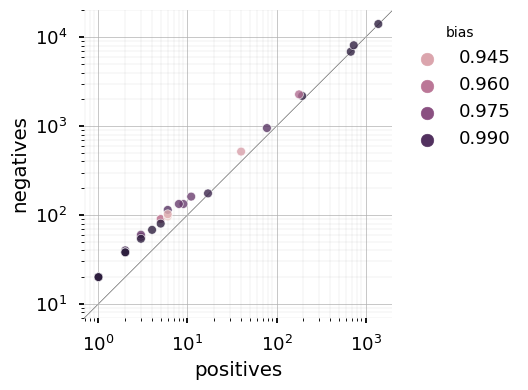

In [61]:
with mpl.rc_context({'figure.dpi': 100}):
    fig = plot_bias(_isp, _isp_negs, _isp_bias, c.ratio)
fig.savefig(f'isp_bias.png', dpi=300, transparent=False)
fig.savefig(f'isp_bias.svg')

#### degrees

/home/k/kaindll/mambaforge/envs/ppi/lib/python3.10/site-packages/seaborn/categorical.py:376: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.set_ylim(-.5, len(self.plot_data) - .5, auto=None)


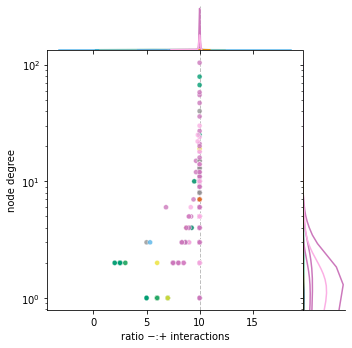

ValueError: Data has no positive values, and therefore can not be log-scaled.

In [149]:
with mpl.rc_context({'figure.dpi': 72}):
    fig, fig2, tdf, tnsp = plot_ratio_degree(
        _isp, _isp_negs, c.ratio, taxonomy)

#### save

In [117]:
isp_pairs = pd.concat((isp, *isp_negatives))
isp_pairs.to_csv(c.isp_tsv, sep='\t', header=True, index=False)
isp_pairs

,hash_A,hash_B,species_A,species_B,source_A,source_B,label
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606,interactome,interactome,1
1,CRC-001576EA78C61C85,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1
2,CRC-003F04A89D9D9298,CRC-5B57ABE4DF6E396E,632,9606,interactome,interactome,1
3,CRC-004D9CE1FF661B75,CRC-2BD0B32F33D454DA,1392,9606,interactome,interactome,1
4,CRC-0054C7CD3E6A8446,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1
...,...,...,...,...,...,...,...
19,CRC-1523145F2EEBCE41,CRC-F3C58B1BB986442D,284812,559292,swissprot,interactome,0
20,CRC-5661166AEB7C6C7A,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0
21,CRC-F488C398D2550275,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0
22,CRC-06395BE71B775DAD,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0


In [85]:
apid_fasta = dict()
sp_fasta = dict()

for s, _fasta in zip(['apid', 'swissprot'], [apid_fasta, sp_fasta]):
    for char in 'AB':
        for j, crc, sp in isp_pairs.loc[isp_pairs[f'source_{char}'] == s,
                                      [f'hash_{char}', f'species_{char}']].itertuples():
            _fasta[crc] = combined_proteome[sp][crc]

In [90]:
len(sp_fasta), len(apid_fasta)

(1629, 1018)

In [103]:
fasta['CRC-00053DA2C582D0E6']

SeqRecord(seq=Seq('MRVDGREKTELRHIHIHTNYLKHPEGSVLIEVGDTKVICSATIEERVPPFMRGE...HIE'), id='CRC-00053DA2C582D0E6', name='CRC-00053DA2C582D0E6', description='CRC-00053DA2C582D0E6', dbxrefs=[])

In [104]:
# all protein sequences, from all three sources
with c.isp_fasta.open('w') as out_fasta:
    for v in values_sorted_by_key({
        **{r.id: {'seq': str(r.seq), 'id': r.id} for r in fasta.values()},
        **apid_fasta, **sp_fasta}):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'apid_isp/apid_interspecies.fasta'

In [105]:
# the extra APID proteins used as negatives
with (c.pp / 'apid_negatives.fasta').open('w') as out_fasta:
    for v in values_sorted_by_key(apid_fasta):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'apid_isp/proteomes/apid_negatives.fasta'

In [106]:
# the SwissProt negatives
with (c.pp / 'sp_negatives.fasta').open('w') as out_fasta:
    for v in values_sorted_by_key(sp_fasta):
        to_fasta(v['id'], v['seq'], out_fasta)
out_fasta.name

'apid_isp/proteomes/sp_negatives.fasta'

In [115]:
k = !grep -c ">" $c.isp_fasta
int(k[0]) == len(np.unique(isp_pairs[['hash_A', 'hash_B']]))

True

#### assign C123 labels

In [118]:
# cluster against train
run_uniqueprot2D(c.isp_fasta, c.train_fasta, c.isp_c3_fasta,
                 c.hval_config_path, not c.rostclust)

rostclust uniqueprot2d --hval-config-path hval_config.json apid_isp/apid_interspecies.fasta apid_train.fasta apid_isp/apid_interspecies_c3.fasta
using temporary directory apid_isp/apid_interspeciesf9eotd8i
extract hvals from alignments: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]
 3332/5921::44698 non-redundant in apid_isp/apid_interspecies.fasta against apid_train.fasta written to apid_isp/apid_interspecies_c3.fasta


In [128]:
isp_pairs = make_c_classes(c.isp_tsv, c.isp_c3_fasta, c.isp_fasta)
isp_pairs

,hash_A,hash_B,species_A,species_B,source_A,source_B,label,cclass
0,CRC-00053DA2C582D0E6,CRC-9F206A319B7E3DD8,1392,9606,interactome,interactome,1,2
1,CRC-001576EA78C61C85,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1,2
2,CRC-003F04A89D9D9298,CRC-5B57ABE4DF6E396E,632,9606,interactome,interactome,1,2
3,CRC-004D9CE1FF661B75,CRC-2BD0B32F33D454DA,1392,9606,interactome,interactome,1,2
4,CRC-0054C7CD3E6A8446,CRC-9BD612534CD2C9EB,9606,333760,interactome,interactome,1,2
...,...,...,...,...,...,...,...,...
40467,CRC-1523145F2EEBCE41,CRC-F3C58B1BB986442D,284812,559292,swissprot,interactome,0,1
40468,CRC-5661166AEB7C6C7A,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0,2
40469,CRC-F488C398D2550275,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0,1
40470,CRC-06395BE71B775DAD,CRC-F3C58B1BB986442D,284812,559292,apid,interactome,0,1


In [129]:
isp_pairs.to_csv(c.isp_tsv, sep='\t', header=True, index=False)
c.isp_tsv

PosixPath('apid_isp/apid_interspecies.tsv')

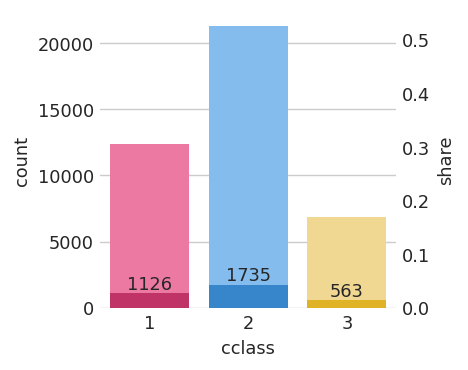

In [130]:
with mpl.rc_context({'figure.dpi': 128}):
    fig, c.isp_sizes = plot_c_classes(isp_pairs)
fig.savefig(f'isp_cclasses_{len(spp)}sp.png', dpi=300, transparent=False)
fig.savefig(f'isp_cclasses_{len(spp)}sp.svg')

In [131]:
c.isp_sizes

{1: 1126, 2: 1735, 3: 563}

In [133]:
with (c.ip / 'cfg.json').open('w') as json_file:
    json_file.write(c.to_json(indent=2))
print(c.to_json(indent=2))

{
  "keep_human": false,
  "keep_interspecies": false,
  "accept_homodimers": false,
  "add_proteomes": true,
  "slurm": true,
  "slurm_node_limit": 15,
  "rostclust": "/home/k/kaindll/mambaforge/envs/ppi/bin/rostclust",
  "cwd": "/home/k/kaindll/ppi/data/ppi_dataset/results/7082",
  "ap": "apid",
  "hp": "huri",
  "qp": "apid_q1",
  "pp": "apid_isp/proteomes",
  "ip": "apid_isp",
  "dp": "homodimers",
  "min_seq_len": 50,
  "max_seq_len": 1500,
  "hval_config": {
    "shortAlignmentLen": 50,
    "longSeqLen": 180,
    "reduceRandomAlign": false,
    "clusterThreshold": 20
  },
  "hval_config_path": "hval_config.json",
  "seed": 42,
  "ratio": 10.0,
  "strategy": 1,
  "val_set_size": 0.1,
  "val_species": [],
  "train_species": [],
  "test_species": [
    333760,
    9986,
    10116,
    83333,
    9606,
    9031,
    10377,
    284812,
    11706,
    7955,
    2697049,
    1111708,
    6239,
    8355,
    10299,
    10090,
    1392,
    37296,
    3702,
    632,
    9913,
    272634,
